# Naive representation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 11) #random number of sources
radius = 1 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 2.41578557e-03+1.01084486e-02j -1.31078474e-02-1.50567980e-03j
  -9.73134208e-03+1.53800026e-02j  1.99496816e-03-3.02145397e-03j
   4.26936895e-03-2.54418631e-03j -5.29096741e-03+1.32190445e-02j
   7.72594986e-03+1.26974760e-02j -2.52037663e-02+8.49493500e-03j
   1.18997577e-03+1.79068837e-02j -6.21372601e-04-6.10934570e-03j]
 [ 3.06518562e-02+1.83622353e-02j -8.34406074e-03-3.78240040e-03j
   2.30806391e-03+5.84462238e-03j  1.80206615e-02-2.07398329e-02j
  -1.74365193e-02-5.56714507e-03j  8.83108843e-03-3.43317306e-03j
  -5.10632480e-03+2.85854423e-03j  1.04323160e-02-1.25452236e-03j
  -3.52235534e-03-9.87583306e-03j -6.53998600e-03-2.30445061e-03j]
 [ 1.95277797e-03-8.06403998e-03j  1.07609387e-02-5.84716490e-03j
  -4.94860439e-03-1.25851613e-02j  1.86862666e-02+6.01698505e-03j
  -3.76383285e-03-3.83363850e-03j  1.42012571e-03+5.07257719e-05j
  -4.29514749e-03-3.10891145e-03j -1.65872108e-02-8.15075822e-03j
   1.99589762e-03-3.32963490e-03j -1.11264279e-02+5.73895872e-03j]
 [ 2.44

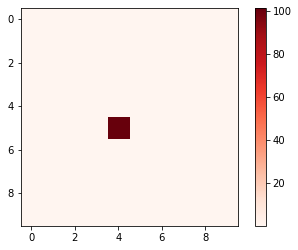

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[  21.104912+99.22618j    41.254173-92.6964j    -87.68275 +50.76037j
   100.74016 +10.571443j  -75.07215 -67.91703j    21.129618+98.9926j
    41.28159 -92.515366j  -87.681335+50.710484j  100.72672 +10.526102j
   -75.214134-67.70722j ]
 [ -21.092777-98.938j     -41.358505+92.57541j    87.79685 -50.630123j
  -100.71641 -10.369172j   75.35857 +67.820656j  -21.051788-98.85317j
   -40.943718+92.6986j     87.83982 -50.934994j -100.71771 -10.545178j
    75.45585 +67.70801j ]
 [  20.853746+99.02115j    41.195198-92.66914j   -87.531624+50.665474j
   100.72152 +10.379539j  -75.502815-67.70929j    21.041515+99.17173j
    41.24009 -92.624344j  -87.70196 +50.55951j   100.824326+10.434176j
   -75.31888 -67.77876j ]
 [ -21.141964-99.04441j   -40.99587 +92.60627j    87.70765 -50.680386j
  -100.63861 -10.629571j   75.37039 +67.586945j  -20.946432-99.04409j
   -41.236427+92.66229j    87.667   -50.733463j -100.72526 -10.466198j
    75.50576 +67.80197j ]
 [  21.213484+99.10423j    41.22883 -92.606255j  -

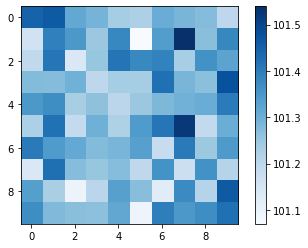

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

In [7]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 3.332357e-14
Imaginaries MSE: 2.493579e-14


In [8]:
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import QFT

In [9]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [10]:
#https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html
#https://quantumcomputinguk.org/tutorials/quantum-fourier-transform-in-qiskit

In [28]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.23.1', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.0', 'qiskit': '0.41.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [25]:
import math

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

In [26]:
"""
def qft(circ, q, n):

    for j in range(n):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])
"""   
pi = np.pi    
def myQFT(qc, q, n):
    for j in range(n):
        for k in range(j):
            qc.cp( pi/(2**(j-k)), q[j], q[k])
        qc.h(q[j])

In [27]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
number_of_qbits = number_of_entries*number_of_bits
off_set = 0

q = QuantumRegister(number_of_qbits)
c = ClassicalRegister(number_of_qbits)

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(q, c)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)
            
myQFT(qc, q, number_of_qbits)
for i in range(number_of_qbits):
    qc.measure(q[i], c[i])

OverflowError: int too large to convert to float

In [12]:
# measurement
qc.measure_all()
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)
result = simulator.run(circ, shots=1, memory=True).result()
memory = result.get_memory(circ)[0]
out = reverse(memory)

#qc.measure_all()
#backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
#job = backend.run(qc, shots=1, memory=True) 
#output = job.result().get_memory()[0]
#out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[  21.104912+99.22618j    41.254173-92.6964j    -87.68275 +50.76037j
   100.74016 +10.571443j  -75.07215 -67.91703j    21.129618+98.9926j
    41.28159 -92.515366j  -87.681335+50.710484j  100.72672 +10.526102j
   -75.214134-67.70722j ]
 [ -21.092777-98.938j     -41.358505+92.57541j    87.79685 -50.630123j
  -100.71641 -10.369172j   75.35857 +67.820656j  -21.051788-98.85317j
   -40.943718+92.6986j     87.83982 -50.934994j -100.71771 -10.545178j
    75.45585 +67.70801j ]
 [  20.853746+99.02115j    41.195198-92.66914j   -87.531624+50.665474j
   100.72152 +10.379539j  -75.502815-67.70929j    21.041515+99.17173j
    41.24009 -92.624344j  -87.70196 +50.55951j   100.824326+10.434176j
   -75.31888 -67.77876j ]
 [ -21.141964-99.04441j   -40.99587 +92.60627j    87.70765 -50.680386j
  -100.63861 -10.629571j   75.37039 +67.586945j  -20.946432-99.04409j
   -41.236427+92.66229j    87.667   -50.733463j -100.72526 -10.466198j
    75.50576 +67.80197j ]
 [  21.213484+99.10423j    41.22883 -92.606255j  -

In [13]:
fidelity = np.fft.ifft2(readout).astype('complex64')

In [14]:
test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 3.332357e-14
Imaginaries MSE: 2.493579e-14


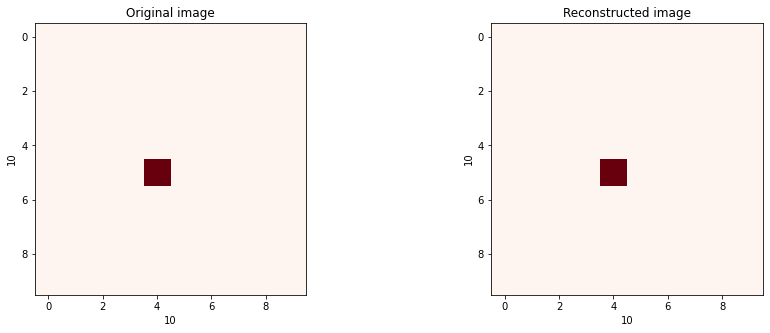

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(fidelity)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)